In [11]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

In [2]:
import sys, platform, torch, torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

batch_size = 32
train = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
test  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

use_workers = 0 if ("ipykernel" in sys.modules or platform.system()=="Windows") else 2

100%|██████████| 170M/170M [00:06<00:00, 25.8MB/s]


In [3]:
trainLoader = DataLoader(train, batch_size=batch_size, shuffle=True,
                         num_workers=use_workers, pin_memory=True)
testLoader  = DataLoader(test,  batch_size=batch_size, shuffle=False,
                         num_workers=use_workers, pin_memory=True)

In [ ]:
print("Классы:", train.classes)
print("Количество классов:", len(train.classes))

Классы: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Количество классов: 10


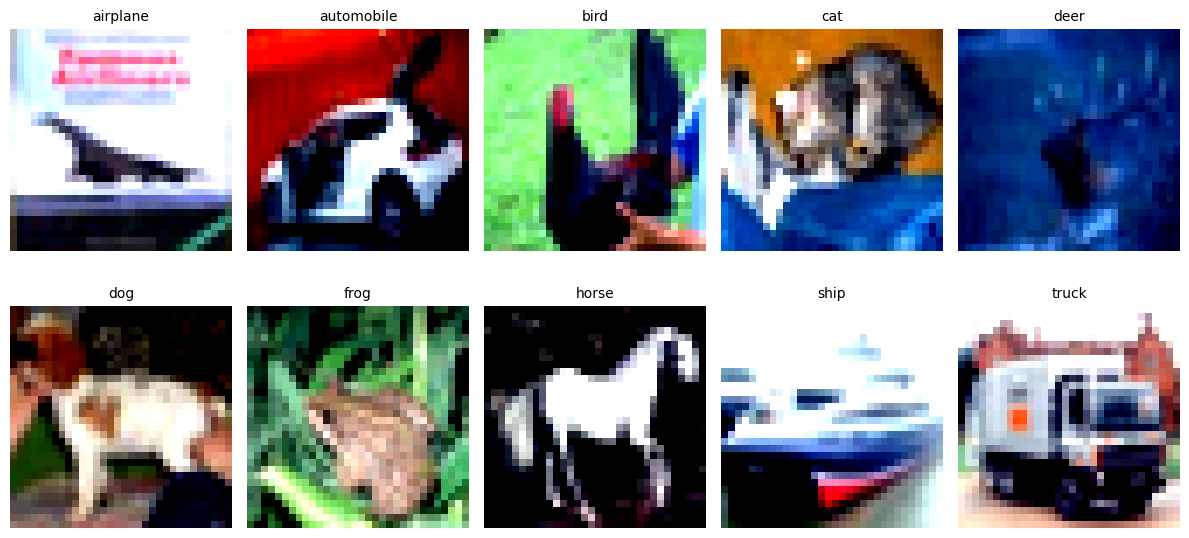

In [4]:
# выведу по одному изображения каждого класса

selected_images = {}
selected_labels = {}

for img, label in test:
    if label not in selected_images:
        selected_images[label] = img
        selected_labels[label] = label
    if len(selected_images) == 10:
        break

plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = selected_images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(train.classes[i], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 176MB/s]


In [5]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os

def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=35,
    device=None,
    step_on="val",
    plot_curves=True,
    plot_accuracy=True,
    save_dir=None,
    early_stop_acc=95.0,
    save_checkpoint_path=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Using {'GPU ' + torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

    def get_lr(optim):
        for pg in optim.param_groups:
            return pg.get("lr", None)

    history = {
        "train_losses": [],
        "train_accuracies": [],
        "test_losses": [],
        "test_accuracies": [],
        "best_test_acc": 0.0,
    }
    best_state = None
    stopped_early = False

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum, train_batches = 0.0, 0
        train_correct, train_total = 0, 0

        for xb, yb in tqdm(train_loader, desc=f"Train {epoch+1}/{num_epochs}", leave=False):
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()
            train_batches += 1
            preds = logits.argmax(1)
            train_total += yb.size(0)
            train_correct += (preds == yb).sum().item()

        train_loss = train_loss_sum / max(1, train_batches)
        train_acc  = 100.0 * train_correct / max(1, train_total)
        history["train_losses"].append(train_loss)
        history["train_accuracies"].append(train_acc)

        model.eval()
        test_loss_sum, test_batches = 0.0, 0
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for xb, yb in tqdm(test_loader, desc=f"Test  {epoch+1}/{num_epochs}", leave=False):
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                vloss = criterion(logits, yb)

                test_loss_sum += vloss.item()
                test_batches += 1

                preds = logits.argmax(1)
                test_total += yb.size(0)
                test_correct += (preds == yb).sum().item()

        test_loss = test_loss_sum / max(1, test_batches)
        test_acc  = 100.0 * test_correct / max(1, test_total)
        history["test_losses"].append(test_loss)
        history["test_accuracies"].append(test_acc)

        if scheduler is not None:
            try:
                metric = test_loss if step_on == "val" else train_loss
                scheduler.step(metric)
            except TypeError:
                scheduler.step()

        lr_now = get_lr(optimizer)
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | "
            f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}% | "
            f"lr: {lr_now:.2e}"
        )

        if test_acc > history["best_test_acc"]:
            history["best_test_acc"] = test_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            if save_checkpoint_path:
                torch.save(best_state, save_checkpoint_path)

        if test_acc >= early_stop_acc:
            # если точность больши или равна 95%
            print(f"Early stop: test accuracy {test_acc:.2f}% ≥ {early_stop_acc:.2f}%.")
            stopped_early = True
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    if plot_curves:
        epochs = range(1, len(history["train_losses"]) + 1)

        plt.figure()
        plt.plot(epochs, history["train_losses"], label="train loss")
        plt.plot(epochs, history["test_losses"], label="test loss")
        plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss vs. epoch")
        plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, "loss_curve.png"), dpi=150, bbox_inches="tight")
        plt.show()

        if plot_accuracy:
            plt.figure()
            plt.plot(epochs, history["train_accuracies"], label="train acc (%)")
            plt.plot(epochs, history["test_accuracies"], label="test acc (%)")
            plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.title("Accuracy vs. epoch")
            plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                plt.savefig(os.path.join(save_dir, "accuracy_curve.png"), dpi=150, bbox_inches="tight")
            plt.show()

    if stopped_early:
        print(f"Best test acc: {history['best_test_acc']:.2f}% (model restored to best).")

    return model, history


Using GPU Tesla T4


Train 1/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  1/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/10] | train_loss: 1.2827 | train_acc: 73.55% | test_loss: 1.1386 | test_acc: 78.76% | lr: 3.00e-04


Train 2/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  2/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/10] | train_loss: 1.1515 | train_acc: 78.58% | test_loss: 1.0808 | test_acc: 81.10% | lr: 3.00e-04


Train 3/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  3/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/10] | train_loss: 1.0422 | train_acc: 82.02% | test_loss: 1.0772 | test_acc: 80.90% | lr: 3.00e-04


Train 4/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  4/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/10] | train_loss: 0.9797 | train_acc: 84.32% | test_loss: 1.0507 | test_acc: 81.93% | lr: 3.00e-04


Train 5/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  5/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/10] | train_loss: 0.9445 | train_acc: 85.54% | test_loss: 1.0392 | test_acc: 82.46% | lr: 3.00e-04


Train 6/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  6/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/10] | train_loss: 0.8753 | train_acc: 87.99% | test_loss: 1.0430 | test_acc: 82.49% | lr: 3.00e-04


Train 7/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  7/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/10] | train_loss: 0.8411 | train_acc: 89.14% | test_loss: 1.0962 | test_acc: 81.80% | lr: 3.00e-04


Train 8/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  8/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/10] | train_loss: 0.8032 | train_acc: 90.65% | test_loss: 1.0620 | test_acc: 83.19% | lr: 3.00e-04


Train 9/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  9/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/10] | train_loss: 0.8210 | train_acc: 90.08% | test_loss: 1.0641 | test_acc: 82.85% | lr: 3.00e-04


Train 10/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  10/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [10/10] | train_loss: 0.7454 | train_acc: 92.82% | test_loss: 1.0843 | test_acc: 83.97% | lr: 1.50e-04


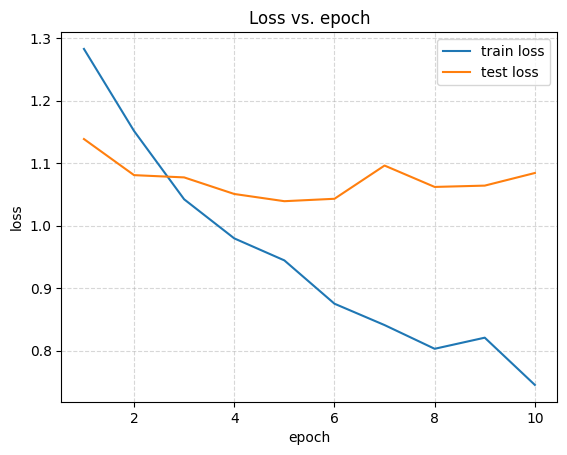

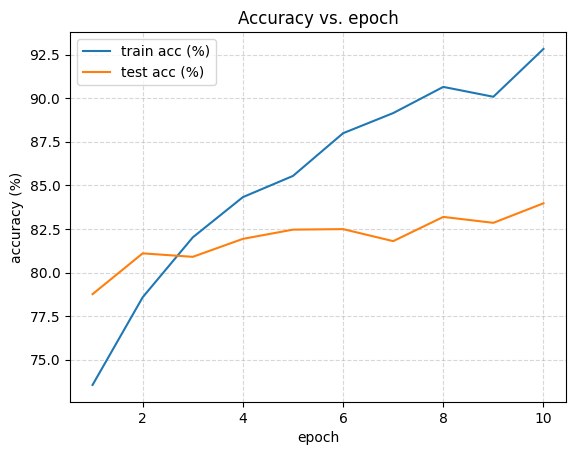

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4)

try:
    model, history = train_model(
        model,
        train_loader=trainLoader,
        test_loader=testLoader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=10,
        step_on="val"
    )
except KeyboardInterrupt:
    print("Прервали обучение, сохраняем уже обученную на данный момент модель")
    torch.save(model.state_dict(), "my_model.pth")

In [6]:

import random

CIFAR10_CLASSES = (
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
)


def evaluate_model(model, test_loader, criterion, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    test_loss_sum, test_batches = 0.0, 0
    correct, total = 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            test_loss_sum += loss.item()
            test_batches += 1

            pred = logits.argmax(1)
            total += yb.size(0)
            correct += (pred == yb).sum().item()

            all_preds.append(pred.cpu())
            all_targets.append(yb.cpu())

    test_loss = test_loss_sum / max(1, test_batches)
    test_acc  = 100.0 * correct / max(1, total)
    print(f"[TEST] loss: {test_loss:.4f} | acc: {test_acc:.2f}%")

    try:
        from sklearn.metrics import classification_report, confusion_matrix
        y_true = torch.cat(all_targets).numpy()
        y_pred = torch.cat(all_preds).numpy()
        print("\nClassification report:")
        print(classification_report(y_true, y_pred, target_names=CIFAR10_CLASSES))

        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation="nearest")
        plt.title("Confusion matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

    return {"test_loss": test_loss, "test_acc": test_acc}


def denormalize(img, mean=(0.4914,0.4822,0.4465), std=(0.2470,0.2435,0.2616)):
    if isinstance(mean, (list, tuple)):
        mean = torch.tensor(mean)[:, None, None]
    if isinstance(std, (list, tuple)):
        std = torch.tensor(std)[:, None, None]
    x = img.cpu()*std + mean
    x = x.clamp(0,1)
    return x.permute(1,2,0).numpy()

def show_predictions(model, dataset_or_loader, device=None, n=10,
                     mean=(0.4914,0.4822,0.4465),
                     std=(0.2470,0.2435,0.2616),
                     class_names=CIFAR10_CLASSES):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    if hasattr(dataset_or_loader, "dataset"):
        ds = dataset_or_loader.dataset
    else:
        ds = dataset_or_loader

    idxs = random.sample(range(len(ds)), k=n)

    plt.figure(figsize=(14, 6))
    with torch.no_grad():
        for i, idx in enumerate(idxs, start=1):
            img, label = ds[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred = logits.argmax(1).item()

            plt.subplot(2, (n+1)//2, i)
            plt.imshow(denormalize(img, mean, std))
            title = f"pred: {class_names[pred]}\ntrue: {class_names[label]}"
            color = "g" if pred == label else "r"
            plt.title(title, color=color, fontsize=10)
            plt.axis("off")
    plt.suptitle("CIFAR-10 predictions", y=1.02)
    plt.tight_layout()
    plt.show()


In [ ]:
# Извлекаем историю метрик
if 'history' in locals():
    train_losses = history["train_losses"]
    val_losses = history["test_losses"]
    train_accuracies = history["train_accuracies"]
    val_accuracies = history["test_accuracies"]

    print(f"Train losses: {train_losses}")
    print(f"Val accuracies: {val_accuracies}")
else:
    print("Обучение не завершено — история недоступна.")

Train losses: [1.2826651266882683, 1.1514704568753698, 1.04222328202967, 0.979731704207925, 0.9445481093663554, 0.8752916040362567, 0.841120819174473, 0.8031932844310256, 0.820960054928419, 0.7454210036623119]
Val accuracies: [78.76, 81.1, 80.9, 81.93, 82.46, 82.49, 81.8, 83.19, 82.85, 83.97]


In [7]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # График потерь (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # График точности (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

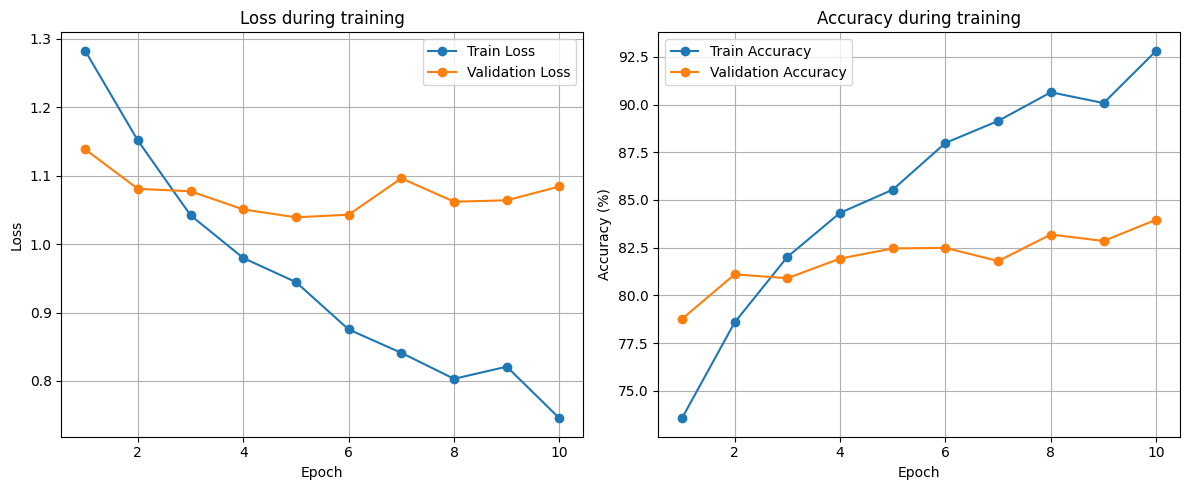

[TEST] loss: 1.0843 | acc: 83.97%

Classification report:
              precision    recall  f1-score   support

    airplane       0.83      0.90      0.86      1000
  automobile       0.93      0.87      0.90      1000
        bird       0.82      0.77      0.79      1000
         cat       0.69      0.71      0.70      1000
        deer       0.82      0.84      0.83      1000
         dog       0.74      0.76      0.75      1000
        frog       0.88      0.89      0.88      1000
       horse       0.90      0.84      0.87      1000
        ship       0.92      0.91      0.91      1000
       truck       0.88      0.91      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



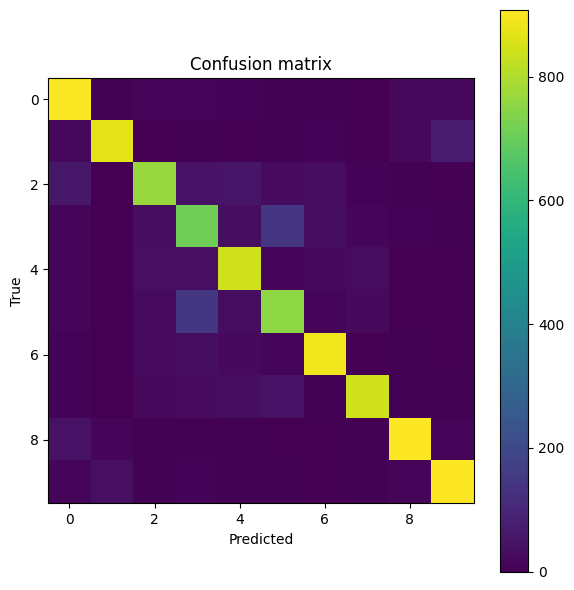

{'test_loss': 1.0842717706966705, 'test_acc': 83.97}


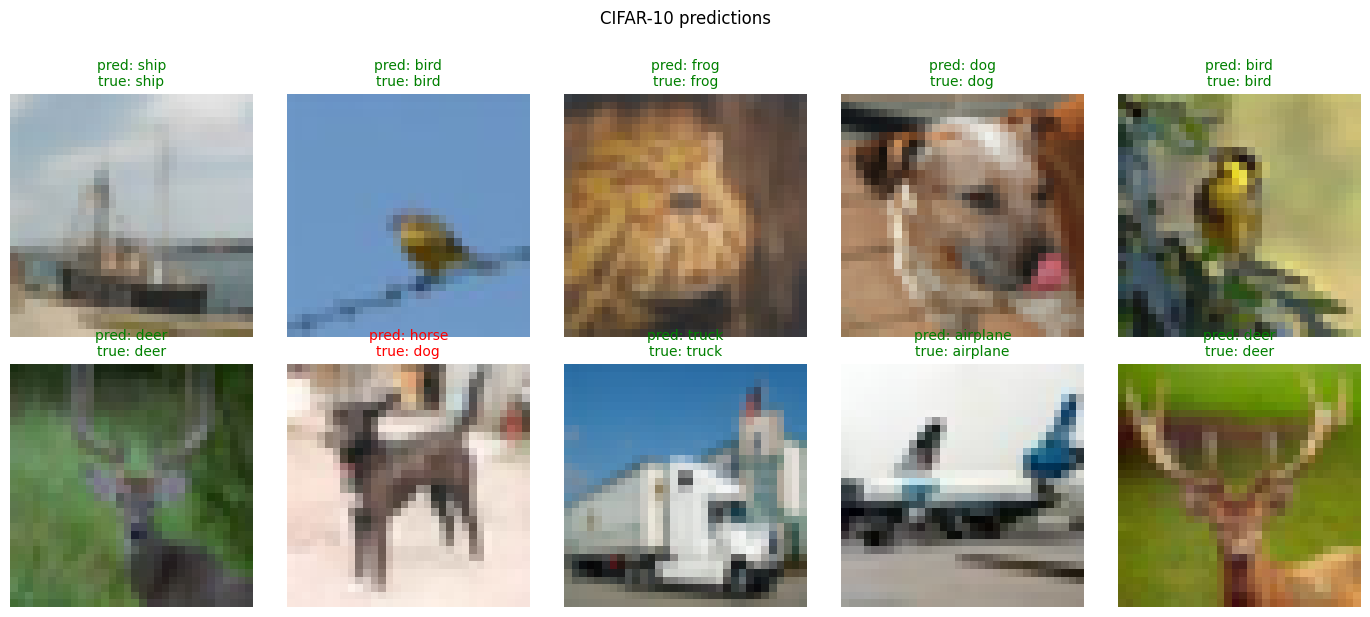

In [ ]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

metrics = evaluate_model(model, testLoader, criterion)
print(metrics)

show_predictions(
    model,
    testLoader,
    n=10,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616)
)

[TEST] loss: 1.0843 | acc: 83.97%

Classification report:
              precision    recall  f1-score   support

    airplane       0.83      0.90      0.86      1000
  automobile       0.93      0.87      0.90      1000
        bird       0.82      0.77      0.79      1000
         cat       0.69      0.71      0.70      1000
        deer       0.82      0.84      0.83      1000
         dog       0.74      0.76      0.75      1000
        frog       0.88      0.89      0.88      1000
       horse       0.90      0.84      0.87      1000
        ship       0.92      0.91      0.91      1000
       truck       0.88      0.91      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



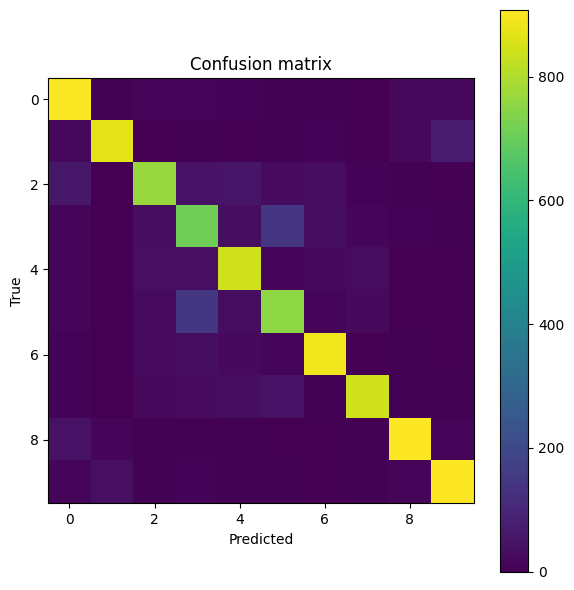

{'test_loss': 1.0842717706966705, 'test_acc': 83.97}


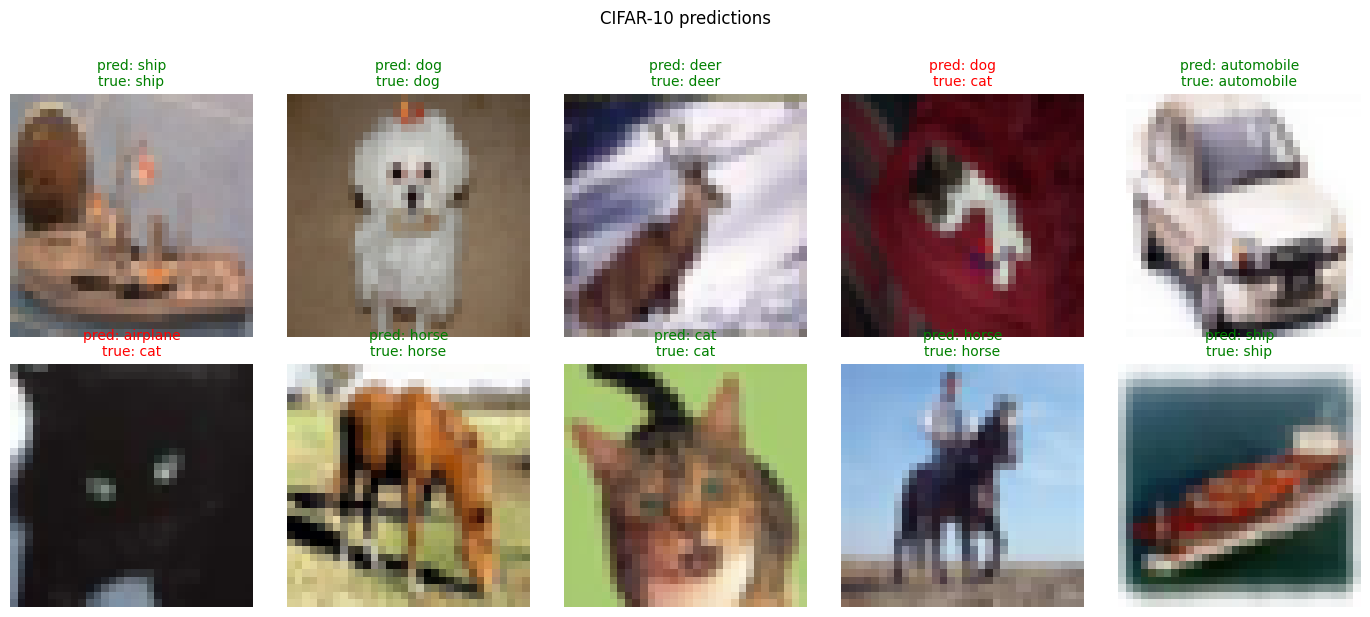

In [ ]:

metrics = evaluate_model(model, testLoader, criterion)
print(metrics)

show_predictions(
    model,
    testLoader,
    n=10,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616)
)



In [12]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT,pretrained=False)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 190MB/s]


Using GPU Tesla T4


Train 1/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  1/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/10] | train_loss: 2.4170 | train_acc: 44.58% | test_loss: 1.6004 | test_acc: 63.93% | lr: 3.00e-04


Train 2/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  2/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/10] | train_loss: 1.5366 | train_acc: 64.77% | test_loss: 1.3403 | test_acc: 72.05% | lr: 3.00e-04


Train 3/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  3/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/10] | train_loss: 1.3435 | train_acc: 71.32% | test_loss: 1.2609 | test_acc: 74.22% | lr: 3.00e-04


Train 4/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  4/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/10] | train_loss: 1.2088 | train_acc: 76.25% | test_loss: 1.1706 | test_acc: 77.92% | lr: 3.00e-04


Train 5/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  5/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/10] | train_loss: 1.1198 | train_acc: 79.27% | test_loss: 1.1641 | test_acc: 78.17% | lr: 3.00e-04


Train 6/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  6/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/10] | train_loss: 1.0468 | train_acc: 81.84% | test_loss: 1.1551 | test_acc: 78.83% | lr: 3.00e-04


Train 7/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  7/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/10] | train_loss: 0.9657 | train_acc: 84.61% | test_loss: 1.0861 | test_acc: 80.36% | lr: 3.00e-04


Train 8/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  8/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/10] | train_loss: 0.9161 | train_acc: 86.69% | test_loss: 1.1019 | test_acc: 80.68% | lr: 3.00e-04


Train 9/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  9/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/10] | train_loss: 0.8624 | train_acc: 88.63% | test_loss: 1.1048 | test_acc: 80.55% | lr: 3.00e-04


Train 10/10:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  10/10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [10/10] | train_loss: 0.8233 | train_acc: 90.00% | test_loss: 1.0810 | test_acc: 82.28% | lr: 3.00e-04


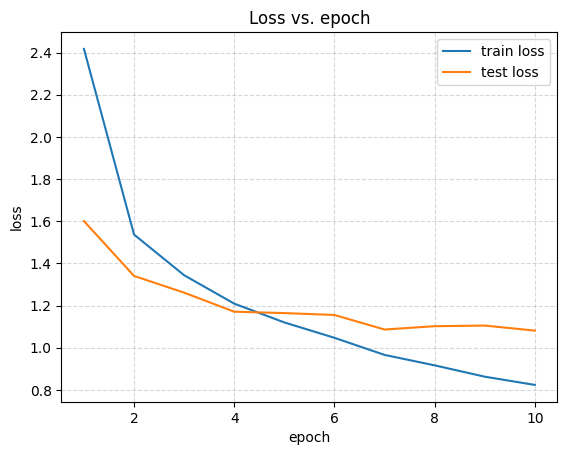

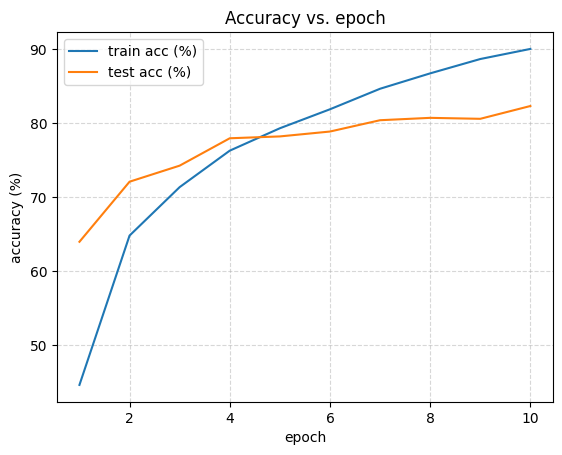

In [13]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4)

try:
    model, history = train_model(
        model,
        train_loader=trainLoader,
        test_loader=testLoader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=10,
        step_on="val"
    )
except KeyboardInterrupt:
    print("Прервали обучение, сохраняем уже обученную на данный момент модель")
    torch.save(model.state_dict(), "my_model.pth")

In [17]:

if 'history' in locals():
    train_losses = history["train_losses"]
    val_losses = history["test_losses"]
    train_accuracies = history["train_accuracies"]
    val_accuracies = history["test_accuracies"]

    print(f"Train losses: {train_losses}")
    print(f"Val accuracies: {val_accuracies}")
else:
    print("Обучение не завершено — история недоступна.")

Train losses: [2.417043116866055, 1.5365645064044593, 1.3434903326891816, 1.2088302288845572, 1.1197570296944674, 1.0467761123859187, 0.9656888140521596, 0.9161277345106987, 0.8623940453114451, 0.8233318087082983]
Val accuracies: [63.93, 72.05, 74.22, 77.92, 78.17, 78.83, 80.36, 80.68, 80.55, 82.28]


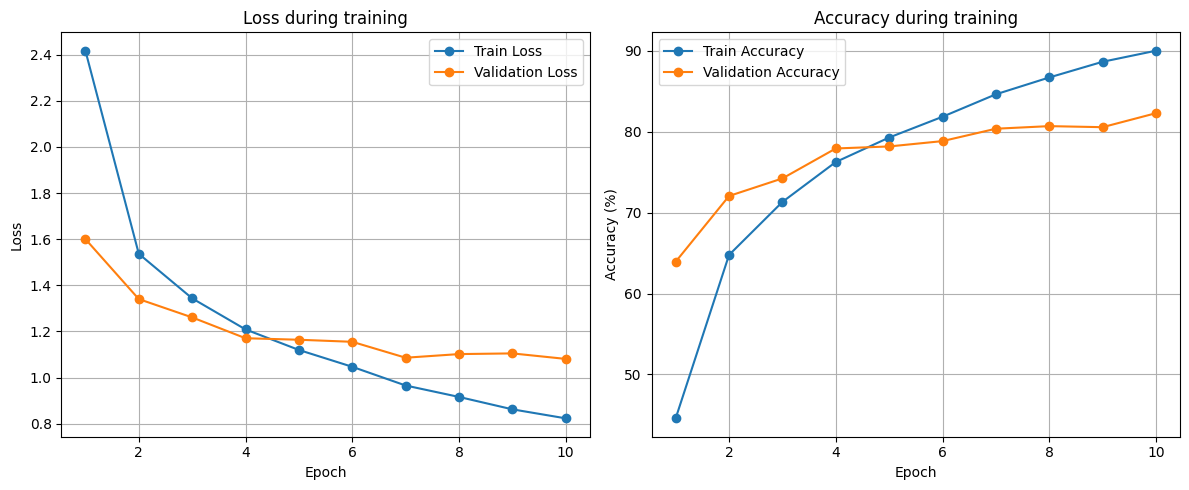

[TEST] loss: 1.0810 | acc: 82.28%

Classification report:
              precision    recall  f1-score   support

    airplane       0.81      0.86      0.84      1000
  automobile       0.85      0.91      0.88      1000
        bird       0.80      0.78      0.79      1000
         cat       0.64      0.69      0.67      1000
        deer       0.78      0.86      0.82      1000
         dog       0.77      0.72      0.74      1000
        frog       0.91      0.84      0.88      1000
       horse       0.89      0.83      0.86      1000
        ship       0.90      0.88      0.89      1000
       truck       0.90      0.84      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



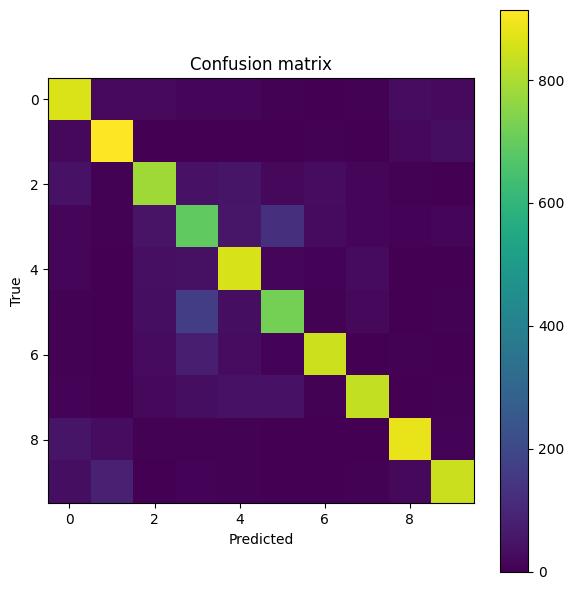

{'test_loss': 1.080972586576931, 'test_acc': 82.28}


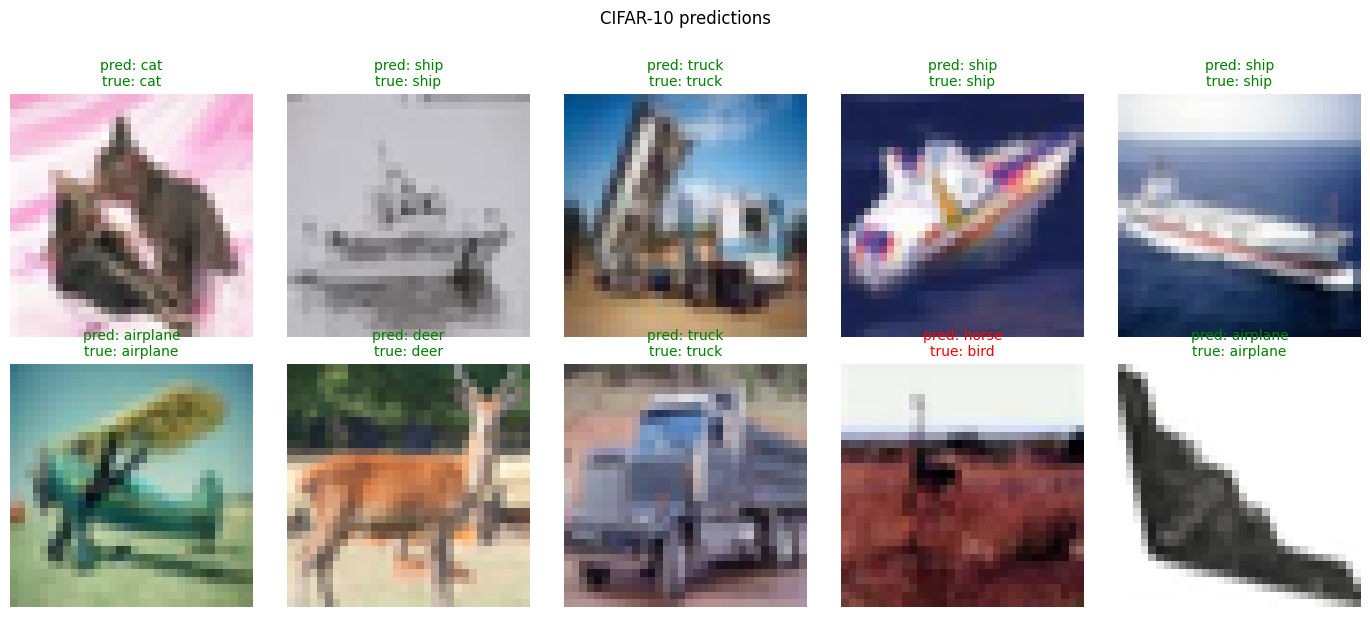

In [16]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

metrics = evaluate_model(model, testLoader, criterion)
print(metrics)

show_predictions(
    model,
    testLoader,
    n=10,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616)
)